In [14]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
# Load dataset
df = pd.read_csv("../data/Restaurant_Reviews.tsv",delimiter='\t')
df.head(5)


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [2]:
# count number of nan values in each column
df.isnull().sum()

Review    0
Liked     0
dtype: int64

In [3]:
# count empy strings in each column                                     
(df == '').sum()

Review    0
Liked     0
dtype: int64

In [4]:
# Handle missing data
df = df.dropna(subset=['Review'])

# TMake sure to split the data first before balancing the dataset
# Otherise it will be data leakage
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
train_data.value_counts('Liked')

Liked
0    404
1    396
Name: count, dtype: int64

## Using upsampling tehnique to address imbalanced data only on train data

In [6]:
# Separate the majority and minority classes
df_majority = train_data[train_data['Liked'] == 0]  # Majority class
df_minority = train_data[train_data['Liked'] == 1]  # Minority class

# Oversample the minority class
df_minority_over = df_minority.sample(len(df_majority), replace=True)

# Combine the majority class with the oversampled minority class
df_balanced = pd.concat([df_majority, df_minority_over])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)


In [7]:
df_balanced.value_counts('Liked')

Liked
0    404
1    404
Name: count, dtype: int64

In [8]:
test_data.value_counts('Liked')

Liked
1    104
0     96
Name: count, dtype: int64

## Tokenize train and test data

In [9]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader


# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews[index])
        label = self.labels[index]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create Dataloaders
def create_data_loader(data, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=data.Review.to_numpy(),
        labels=data.Liked.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

MAX_LEN = 128
BATCH_SIZE = 16
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)
  


## Train the model

Epoch 1/3
Train loss: 0.6252, Train accuracy: 0.6625
Val loss: 0.3618, Val accuracy: 0.9100
Precision: 0.9117, Recall: 0.9100, F1-Score: 0.9100


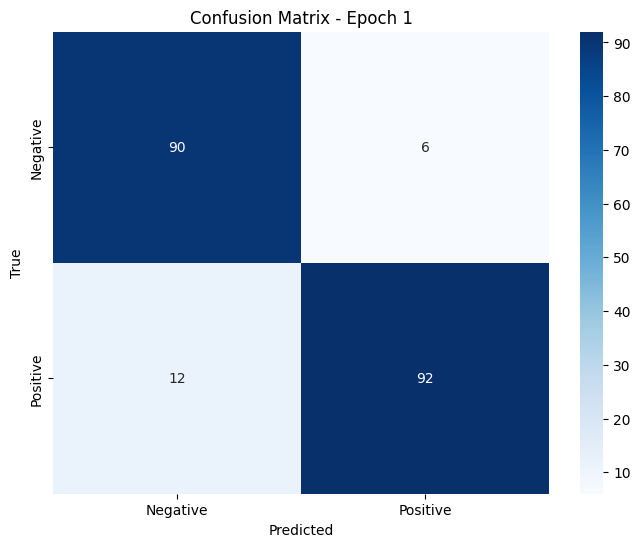

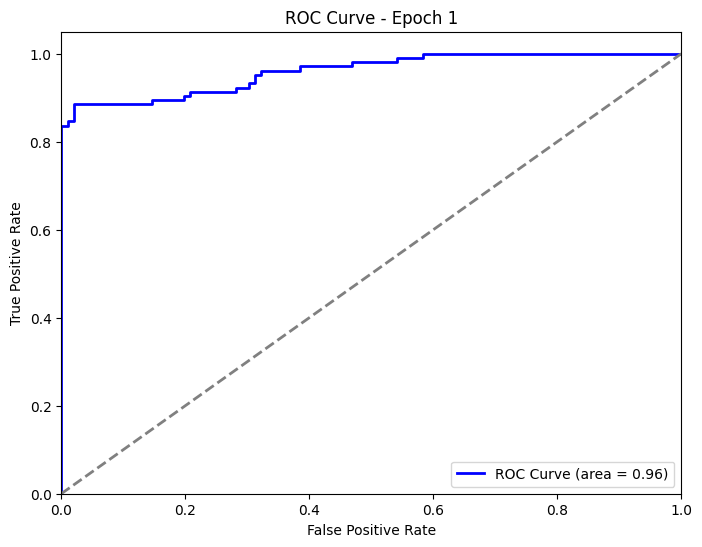

Epoch 2/3
Train loss: 0.2265, Train accuracy: 0.9313
Val loss: 0.1907, Val accuracy: 0.9200
Precision: 0.9265, Recall: 0.9200, F1-Score: 0.9199


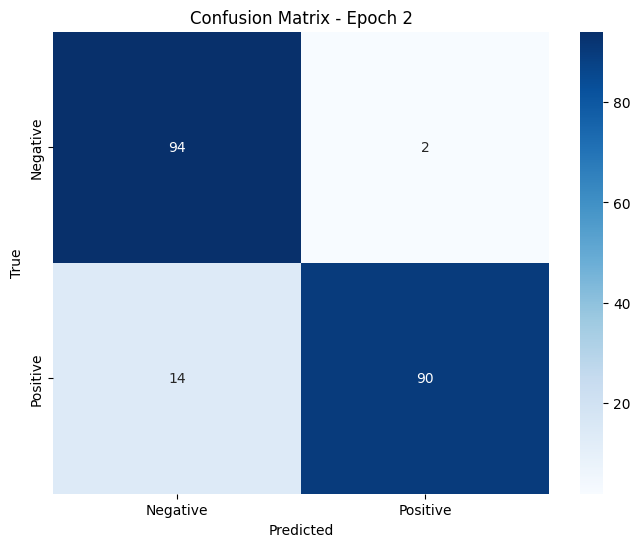

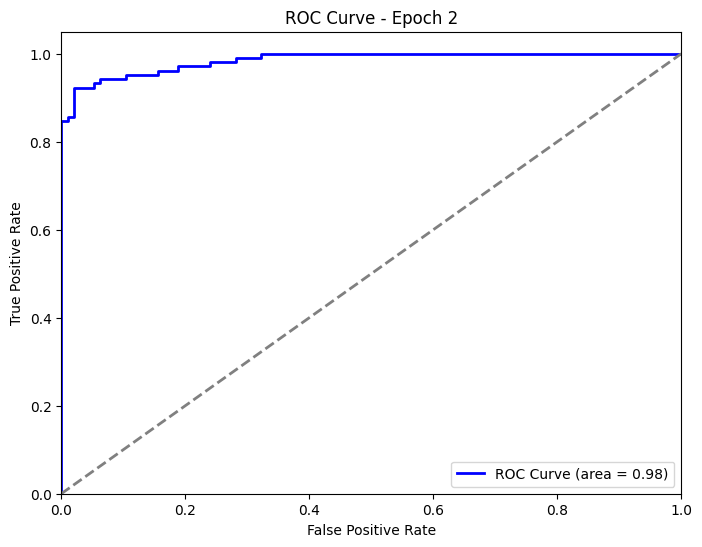

Epoch 3/3
Train loss: 0.1014, Train accuracy: 0.9775
Val loss: 0.1527, Val accuracy: 0.9500
Precision: 0.9517, Recall: 0.9500, F1-Score: 0.9500


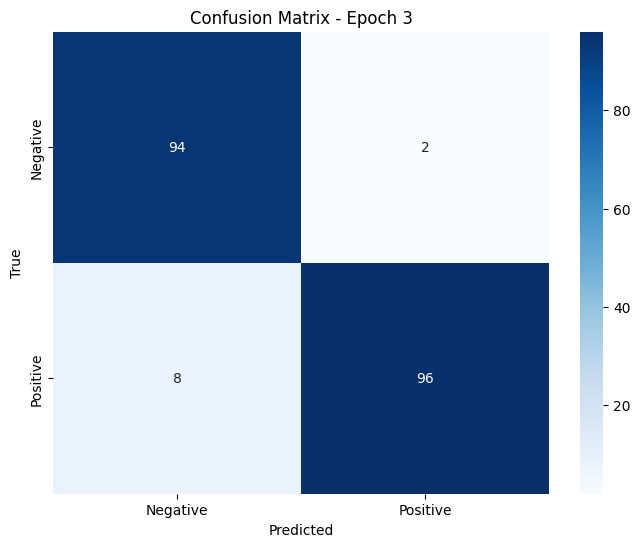

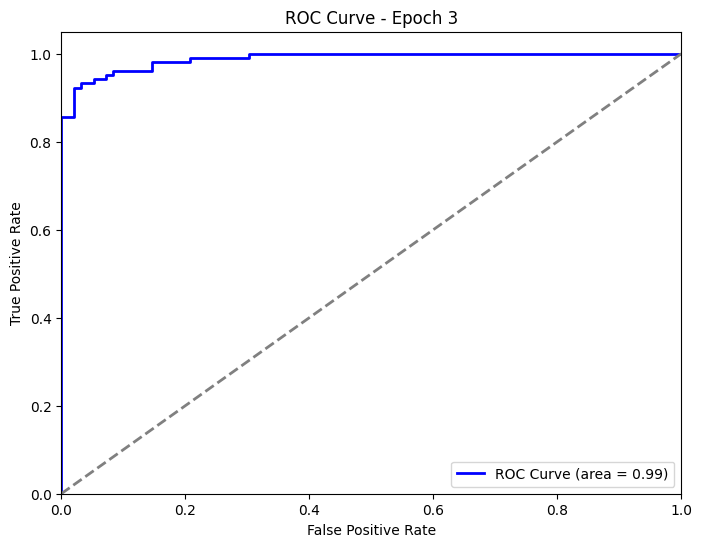

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import BertModel, get_linear_schedule_with_warmup
import numpy as np
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 3

# Initialize BERT tokenizer model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # BERT returns a tuple: (last_hidden_state, pooled_output)
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]  # Extract the pooled_output (i.e., the [CLS] token representation)

        output = self.drop(pooled_output)  # Apply dropout to the pooled output
        return self.out(output)


model = SentimentClassifier(n_classes=2)
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Scheduler
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Training loop
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Updated eval_model function to return predictions and true labels
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()  # Set the model to evaluation mode
    losses = []
    correct_predictions = 0
    all_preds = []
    all_probs = []  # For storing softmax probabilities
    all_labels = []

    with torch.no_grad():  # No gradient calculations in evaluation
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs, dim=1)  # Get softmax probabilities
            _, preds = torch.max(probs, dim=1)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
            correct_predictions += torch.sum(preds == labels).item()

            # Collect predictions and true labels for metrics and confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Get probabilities for the positive class

    avg_loss = sum(losses) / len(losses)  # Average loss
    accuracy = correct_predictions / n_examples  # Calculate accuracy

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, avg_loss, precision, recall, f1, all_labels, all_preds, all_probs

# Training Loop
history = {
    'train_acc': [],
    'train_loss': [],
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}


# train the model
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_data))
    val_acc, val_loss, precision, recall, f1, y_true, y_pred, y_probs = eval_model(model, val_data_loader, loss_fn, device, len(val_data_loader.dataset))
    
    # Store metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
    plt.show()

    # Compute and display ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)  # Get false positive and true positive rates
    roc_auc = auc(fpr, tpr)  # Compute AUC

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Epoch {epoch + 1}')
    plt.legend(loc='lower right')
    plt.show()


In [12]:
import torch
# Save the model
torch.save(model, '../model/model.pth')
